In [62]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import db_utils
from dataset_utils import load_dataset

from sklearn.manifold import TSNE

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Find best perplexity
* Find best perplexity according to 3 constraint-preserving scores and 5 metric scores
* We will have 8 visualization with (maybe different) perplexity found by quality measure scores
* We will build a `meta-map` (by t-SNE) for each dataset
* We show at the same time 9 scatter plots (8 vizs and 1 meta-map)

### Planing steps to follow:
1. Load constraint-scores and metric scores
2. For constraint-scores with auto-generated constraints, use `n_constraints=50`
3. For metric-scores, find `argmax` of bounded metrics and `argmin` of unbounded metrics
4. Build (or load) the metamap. Make a mechanisme to find the embedding corresponding to a given perp
5. Build a big subplots with 9 children scatters
6. Add anotation for big chart

In [566]:
metric_names = {
    'auc_rnx': '$AUC_{log}RNX$',
    'pearsonr': 'CC',
    'cca_stress': 'CCA',
    'mds_isotonic': 'nMDS',
    'sammon_nlm': 'NLM'
}

constraint_names = {
    's_all': '$S_{M+C}$',
    's_ml': '$S_{M}$',
    's_cl': '$S_{C}$'
}

def get_name_by_key(key):
    return {**metric_names, **constraint_names}[key]

dataset_names = [
    'MNIST-SMALL',
    'COIL20',
    'COUNTRY-2014',
    'BREAST-CANCER95',
    'MPI',
    'DIABETES'
]

In [699]:
dataset_name = 'COUNTRY-2014'
embedding_dir = './output/{}'.format(dataset_name)
X, y, labels = load_dataset(dataset_name)

Loading dataset: COUNTRY-2014


### STEP[1,2]: load constraint and metric scores (n_constraints=50)

In [700]:
def load_scores(dataset_name = 'MNIST-SMALL', standardized=False, auto_constraint=50):
    # print('Loading scores for ', dataset_name)
    db_name = 'DB_{}'.format(dataset_name)
    metric_key_name = 'metrics'
    if auto_constraint is not None:
        constraint_key_name = 'constraints'
        n_constraints = auto_constraint
    else:
        constraint_key_name = 'manual_constraints'
        n_constraints = 10

    # load metric scores and sort the record by perplexity
    dfm = db_utils.load_data(db_name, metric_key_name)
    # dfm = dfm.sort_values('perp')
    # remove record with max_perp
    dfm = dfm[dfm.perp < dfm.perp.max()]
    # for consistence with the structure of dfc
    dfm = dfm.groupby('perp').mean()
    
    # load constraint scores
    dfc = db_utils.load_data(db_name, constraint_key_name)    
    # get constraint-scores only for the records with `n_constraints`
    dfc = dfc[dfc.n_constraints == n_constraints]
    # remove record with max_perp
    dfc = dfc[dfc.perp < dfc.perp.max()]
    # group by perplexity
    dfc = dfc.groupby('perp').mean()
    
    return dfm, dfc

In [701]:
dfm, dfc = load_scores(dataset_name, auto_constraint=None)

In [702]:
dfc.head()

,n_constraints,reproduce_seed,s_all,s_cl,s_ml
perp,,,,,
1.000000,10,-1,0.155608,14.431695,-14.276087
1.011094,10,-1,0.235713,14.050876,-13.815163
1.022311,10,-1,0.126894,13.884114,-13.757220
1.033652,10,-1,0.266057,14.552157,-14.286100
1.045119,10,-1,-0.059153,14.187268,-14.246421


### STEP3: Find best perp according the scores

In [703]:
p_sall = dfc.s_all.idxmax()
p_sml = dfc.s_ml.idxmax()
p_scl = dfc.s_cl.idxmax()

p_auc = dfm.auc_rnx.idxmax()
p_pearsonr = dfm.pearsonr.idxmax()
p_cca = dfm.cca_stress.idxmin()
p_mds = dfm.mds_isotonic.idxmin()
p_nlm = dfm.sammon_nlm.idxmin()

In [704]:
print([p_sall, p_sml, p_scl, p_auc, p_pearsonr, p_cca, p_mds, p_nlm])

[64.73949085004024, 141.69758584785146, 1.1930626500679176, 6.242825820991403, 243.30086556901676, 243.30086556901676, 243.30086556901676, 243.30086556901676]


### STEP4: Load or build metatmap

#### Build features for meatmap and a mapping between perplexity value and the corresponding pre-calculated embedding

In [705]:
# load calculated embedding for different value of perplexity
import joblib
import os

embeddings = []
perps = []
all_losses = []

emb_idx = 0
for file in os.listdir(embedding_dir):
    if file.endswith('.z'):
        in_name = os.path.join(embedding_dir, file)
        tsne_obj = joblib.load(in_name)
        embeddings.append(tsne_obj.embedding_.ravel())
        all_losses.append(tsne_obj.kl_divergence_)
        perps.append(tsne_obj.get_params()['perplexity'])
        
        
embeddings = np.array(embeddings)

In [706]:
print(embeddings.shape)
print(perps.index(p_sall))

(500, 492)
147


#### Build metamap from above features in `embeddings`

In [707]:
meta_tsne = TSNE(perplexity=5, n_iter=1500, random_state=0) # 20 for MNIST-SMALL, 5 for COIL20, 5 for COUNTRY-2014
meta_map = meta_tsne.fit_transform(embeddings)
print(meta_tsne)

TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1500, n_iter_without_progress=300, perplexity=5,
   random_state=0, verbose=0)


### STEP[5,6]: Build big chart of 9 scatters and make it look cool

In [708]:
from matplotlib.ticker import FuncFormatter

def exp_format(x, pos):
    """The two args are the value and tick position.
    Label ticks with the product of the exponentiation"""
    return int(np.exp(pos))

In [709]:
from matplotlib import colorbar

def _plot_metamap(fig, ax):
    sct = ax.scatter(meta_map[:, 0], meta_map[:, 1], c=np.log(perps), alpha=0.5, s=80)
    ax.axis('off')
    ax.set_title('{} metamap'.format(dataset_name))
    # colorbar
    cbar = fig.colorbar(sct, ax=ax)
    cbar.ax.set_ylabel('Perplexity')
    cbar.ax.yaxis.set_major_formatter(FuncFormatter(exp_format))


def _scatter(ax, perp_val, key_name, key_idx):
    title = get_name_by_key(key_name)
    idx = perps.index(perp_val)
    emb = embeddings[idx].reshape(-1,2)
    ax.scatter(emb[:, 0], emb[:, 1], c=y, alpha=0.8, cmap='tab10')
    ax.set_title('({}) {}'.format(key_idx, title))
    ax.axes.set_xlabel('[perp={:.3f}]'.format(perp_val))
    ax.set_xticklabels([])
    ax.tick_params('x', length=0)
    ax.get_yaxis().set_visible(False)
    
    
def _annote_metamap(ax, best_perps, key_idx):
    perp_val = best_perps[0]
    idx = perps.index(perp_val)
    (p0, p1) = meta_map[idx, 0], meta_map[idx, 1]
    ax.scatter(p0, p1, marker='+', s=200, color='red')

    offset = 30
    t0 = p0 + np.random.uniform(-2, 2) * offset
    up_or_down = 1 if np.random.uniform(-1, 1) < 0 else -1
    t1 = p1 + np.random.uniform(1.5, 3) * offset * up_or_down
    arrow_args=dict(arrowstyle="->",connectionstyle="arc3,rad=.2")
    ax.annotate('({})'.format(key_idx),
                xy=(p0, p1), xycoords="data",
                # xytext=xytext, textcoords='axes fraction',
                xytext=(t0,t1),
                ha="center", va="top",fontsize=24,
                arrowprops=arrow_args)

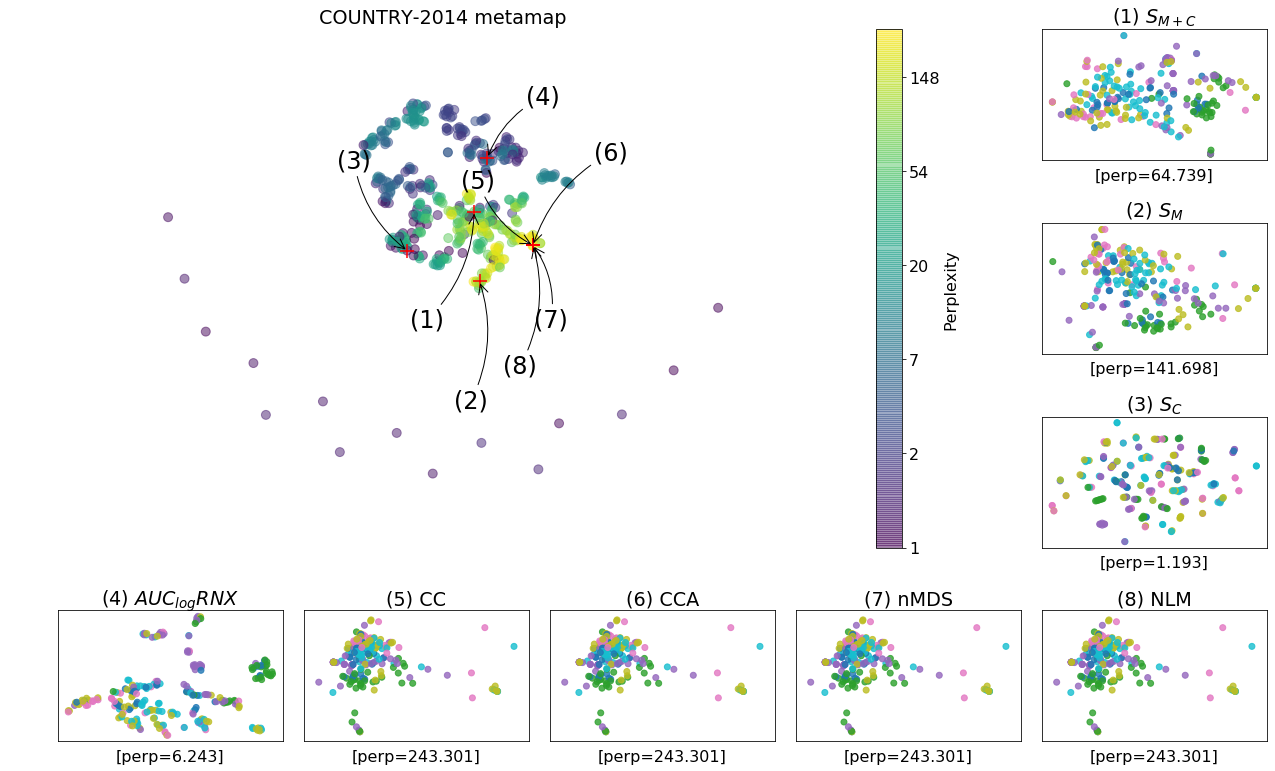

In [715]:
plt.figure(figsize=(18,11))
gr = (4,5)
ax0 = plt.subplot2grid(gr, (0, 0), colspan=4, rowspan=3)

ax1 = plt.subplot2grid(gr, (0, 4))
ax2 = plt.subplot2grid(gr, (1, 4))
ax3 = plt.subplot2grid(gr, (2, 4))

ax4 = plt.subplot2grid(gr, (3, 0))
ax5 = plt.subplot2grid(gr, (3, 1))
ax6 = plt.subplot2grid(gr, (3, 2))
ax7 = plt.subplot2grid(gr, (3, 3))
ax8 = plt.subplot2grid(gr, (3, 4))

ax0.margins(0.2)
_plot_metamap(fig, ax0)

_scatter(ax1, p_sall, 's_all', 1)
_scatter(ax2, p_sml, 's_ml', 2)
_scatter(ax3, p_scl, 's_cl', 3)

_scatter(ax4, p_auc, 'auc_rnx', 4)
_scatter(ax5, p_pearsonr, 'pearsonr', 5)

_scatter(ax6, p_cca,  'cca_stress', 6)
_scatter(ax7, p_mds, 'mds_isotonic', 7)
_scatter(ax8, p_nlm, 'sammon_nlm', 8)

_annote_metamap(ax0, [p_sall], 1)
_annote_metamap(ax0, [p_sml], 2)
_annote_metamap(ax0, [p_scl], 3)

_annote_metamap(ax0, [p_auc], 4)
_annote_metamap(ax0, [p_pearsonr], 5)

_annote_metamap(ax0, [p_cca], 6)
_annote_metamap(ax0, [p_mds], 7)
_annote_metamap(ax0, [p_nlm], 8)

plt.rcParams.update({'font.size': 16})
plt.tight_layout()
plt.savefig('./plots/{}_meta_manual.pdf'.format(dataset_name))